In [10]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
%autoreload 2
import numpy as np
from scipy.linalg import khatri_rao
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [12]:
def gauss(x, r, seed):
    np.random.seed(seed)
    return np.random.normal(size = (x, r))

def radem(x, r, seed):
    np.random.seed(seed)
    return 1 - 2 * np.random.randint(low = 0, high = 2, size = (x, r))

def big_gauss(x, r, seed):
    np.random.seed(seed)
    return np.random.normal(size = (x * x, r))

def big_radem(x, r, seed):
    np.random.seed(seed)
    return 1 - 2 * np.random.randint(low = 0, high = 2, size = (x * x, r))

def gauss_gauss(x, r, seed):
    return khatri_rao(gauss(x, r, seed=2 * seed), gauss(x, r, seed=2 * seed + 1))

def gauss_radem(x, r, seed):
    return khatri_rao(gauss(x, r, seed=2 * seed), radem(x, r, seed=2 * seed + 1))

def radem_radem(x, r, seed):
    return khatri_rao(radem(x, r, seed=2 * seed), radem(x, r, seed=2 * seed + 1))

In [13]:
def generate_almost_unit(n, m, noise, seed):
    def inverse_permutation(p):
        p = np.asanyarray(p)
        s = np.empty_like(p)
        s[p] = np.arange(p.size)
        return s

    assert n >= m
    np.random.seed(seed)
    matrix = np.zeros((n, m))
    for i in range(m):
        matrix[i, i] = 1
    noise_matrix = np.random.normal(0, noise, (n, m))
    matrix += noise_matrix
    perm = np.random.permutation(m)
    matrix = matrix[:, perm]
    q, r = np.linalg.qr(matrix, mode='reduced')
    return q[:, inverse_permutation(perm)]

In [36]:
expected = []
variance = []
n = 70
for base in [1.01, 1.05, 1.18, 1.5, 2, 4.5, 10]:
    for m in range (n, 5 * n + 1, n):
        u = generate_almost_unit(m, m, 0.1, seed = 0)
        vT = generate_almost_unit(n * n, m, 0.01, seed=0).T
        noise = np.random.normal(0, 1, m)
        sigma = np.logspace(0, -m, base=base, num=m)
        sigma = np.flip(np.sort(noise * sigma * noise))
        # print(sigma)
        A = u @ np.diag(sigma) @ vT
        for generator, name in zip([big_gauss, gauss_gauss], ['big_gauss', 'gauss_gauss']):
            for r in [20, 27, 33, 40, 47, 53, 60]:
                precisions = []
                for seed in range(1, 2001):
                    Omega = generator(n, r, seed)
                    Q, R = np.linalg.qr(A @ Omega)
                    B = Q @ (Q.T @ A)
                    precisions.append(np.linalg.norm(A - B) ** 2)
                precisions = np.array(precisions)
                # print(precisions.mean() / (np.linalg.norm(A - C) ** 2))
                C = u[:,:r] @ np.diag(sigma[:r]) @ vT[:r, :]
                expected.append((r, precisions.mean() / (np.linalg.norm(A - C) ** 2), name, base, m))
                variance.append((r, precisions.var() / (np.linalg.norm(A - C) ** 2), name, base, m))
df_expected = pd.DataFrame(expected, columns=["rank", "precision", "generator_name", "base", "row_size"])
df_variance = pd.DataFrame(variance, columns=["rank", "precision", "generator_name", "base", "row_size"])

/tmp/ipykernel_17717/3297516332.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  expected.append((r, precisions.mean() / (np.linalg.norm(A - C) ** 2), name, base, m))
/tmp/ipykernel_17717/3297516332.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  variance.append((r, precisions.var() / (np.linalg.norm(A - C) ** 2), name, base, m))


Base =  1.01  m =  70


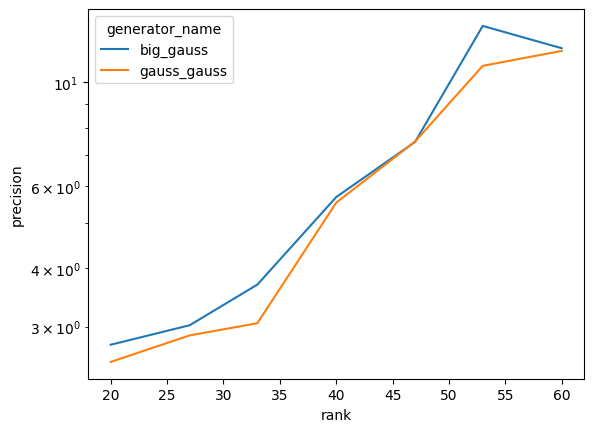

Base =  1.01  m =  140


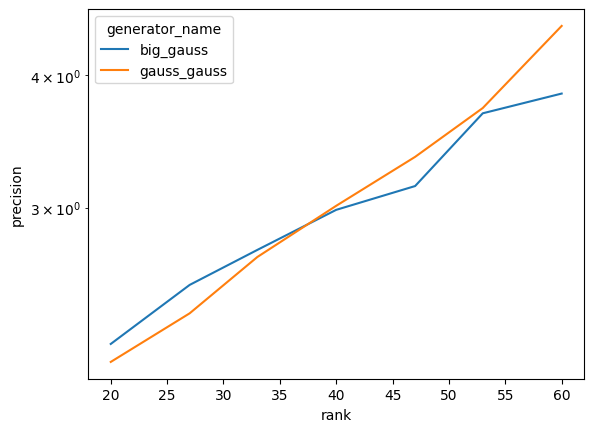

Base =  1.01  m =  210


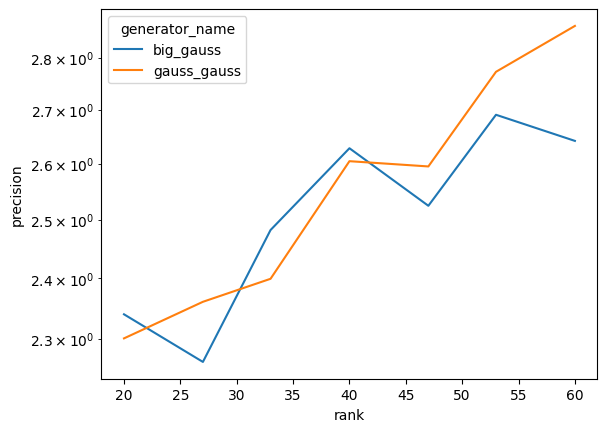

Base =  1.01  m =  280


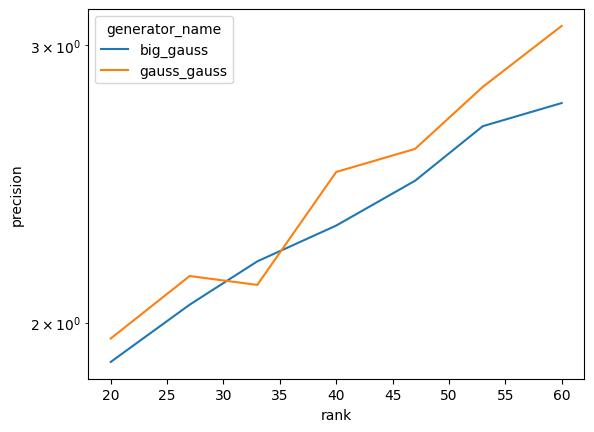

Base =  1.01  m =  350


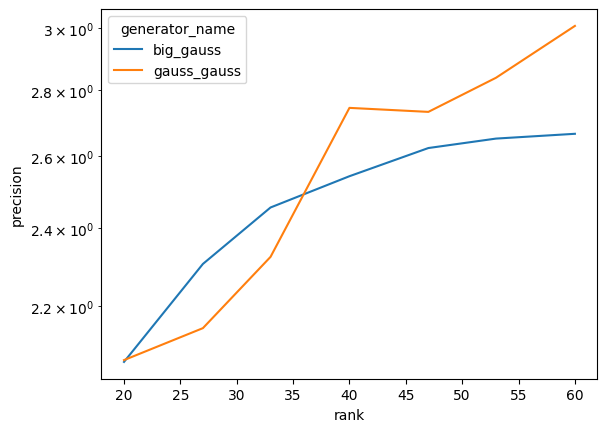

Base =  1.05  m =  70


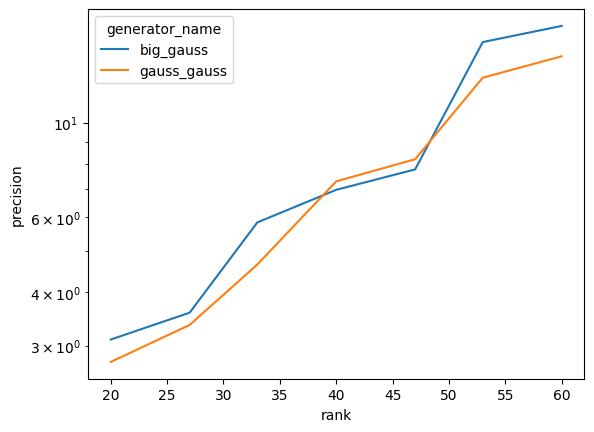

Base =  1.05  m =  140


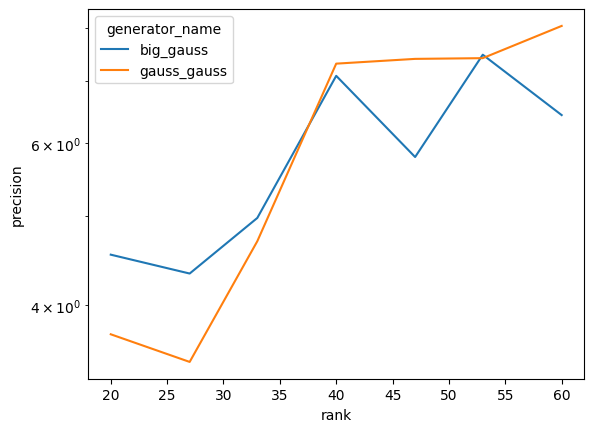

Base =  1.05  m =  210


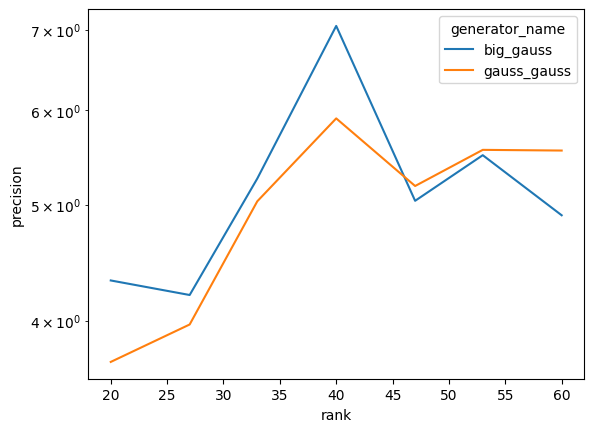

Base =  1.05  m =  280


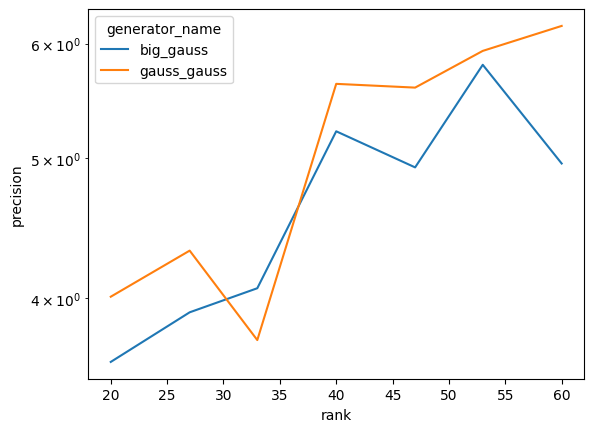

Base =  1.05  m =  350


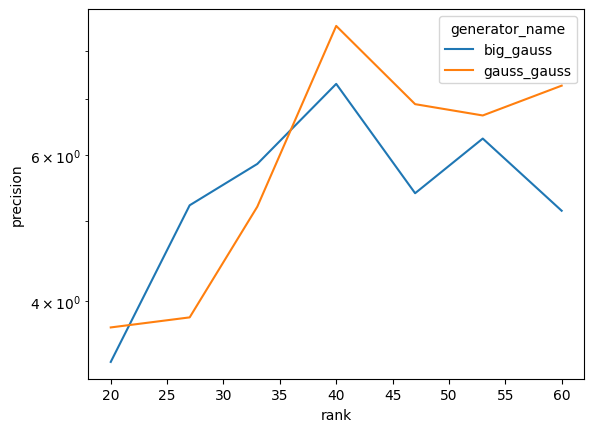

Base =  1.18  m =  70


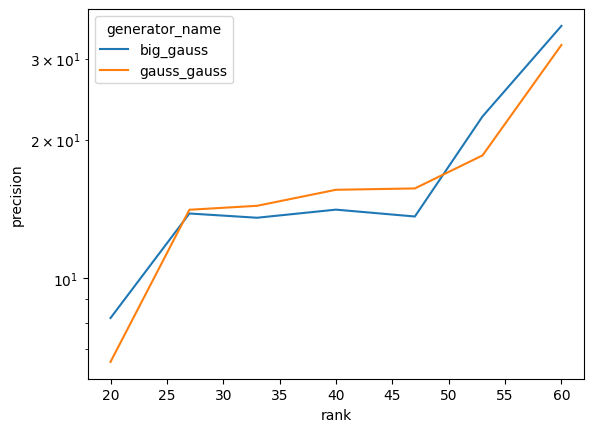

Base =  1.18  m =  140


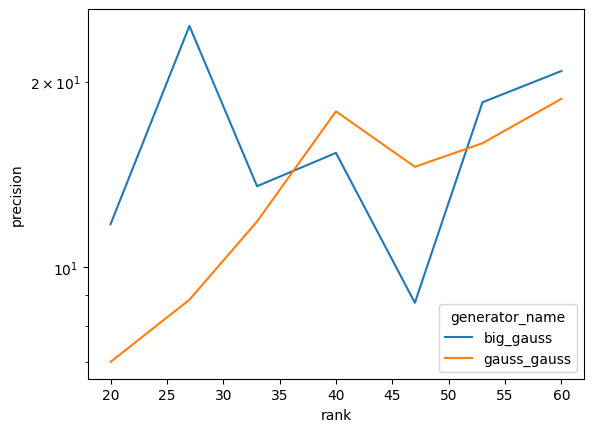

Base =  1.18  m =  210


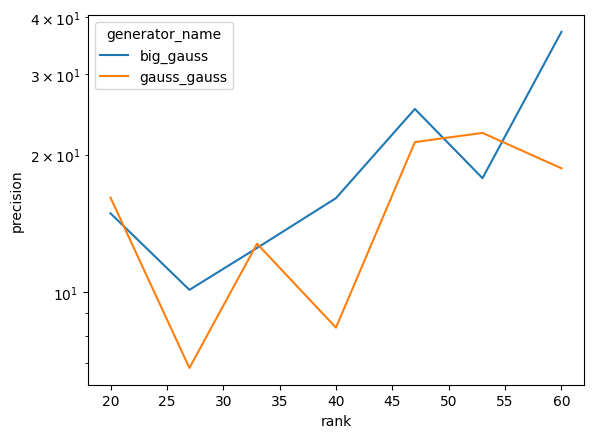

Base =  1.18  m =  280


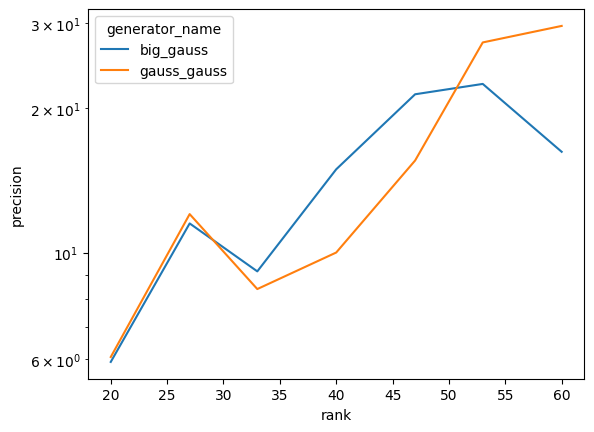

Base =  1.18  m =  350


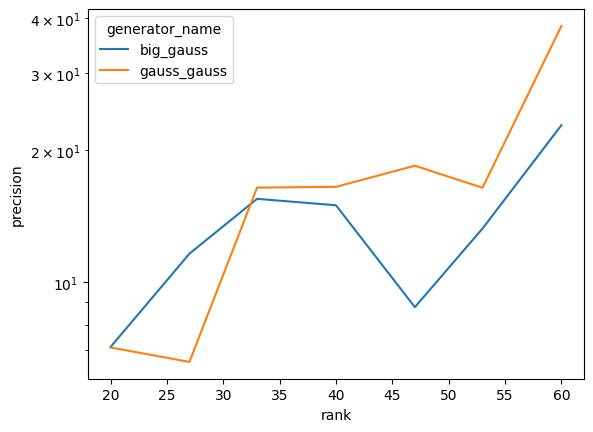

Base =  1.5  m =  70


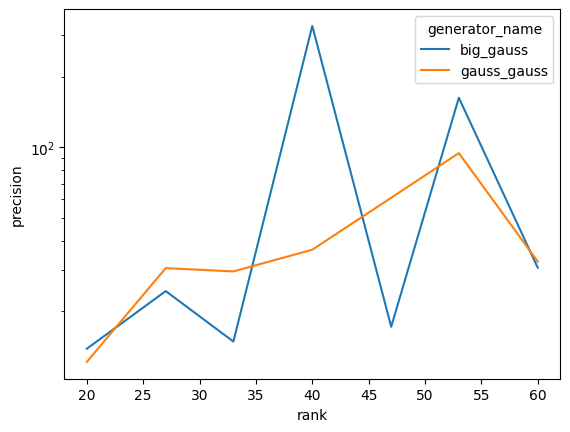

Base =  1.5  m =  140


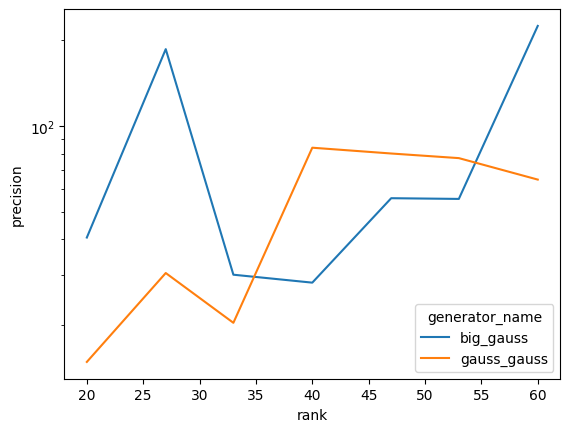

Base =  1.5  m =  210


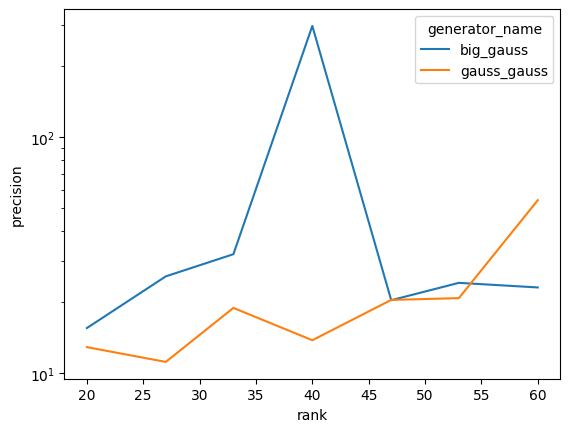

Base =  1.5  m =  280


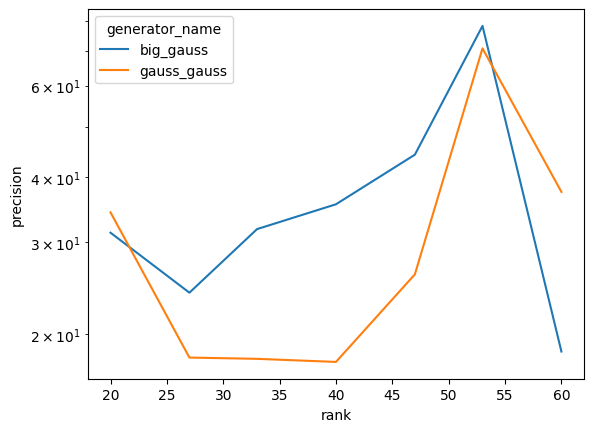

Base =  1.5  m =  350


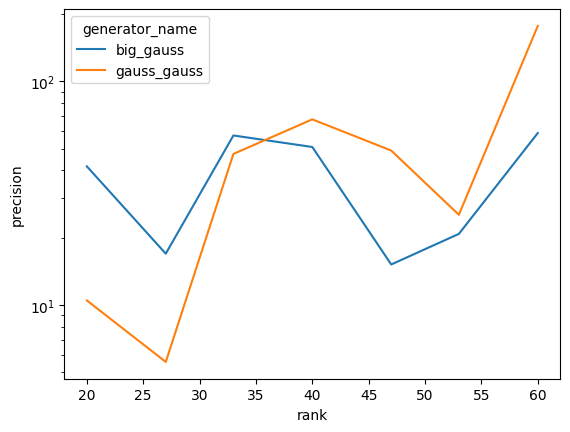

Base =  2  m =  70


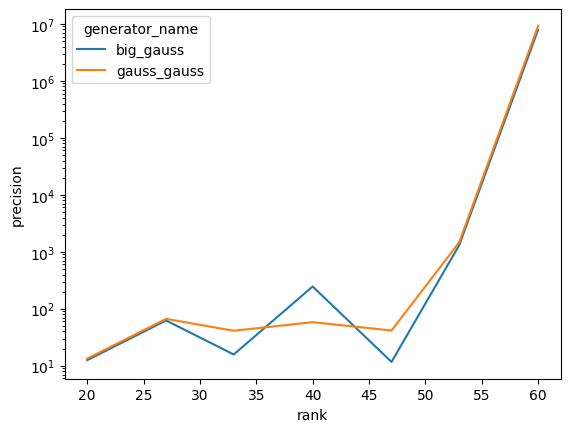

Base =  2  m =  140


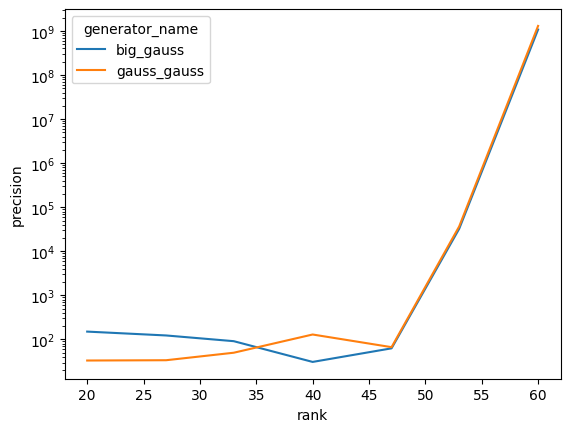

Base =  2  m =  210


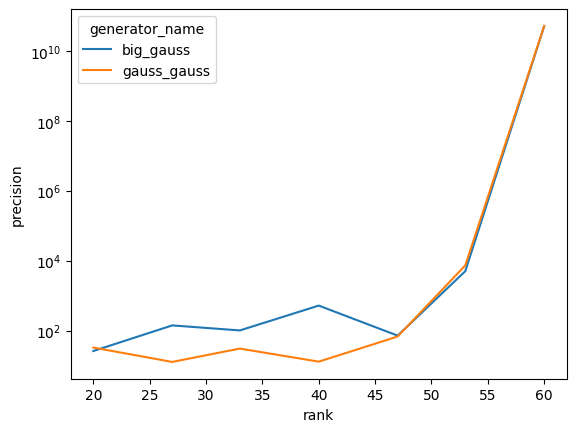

Base =  2  m =  280


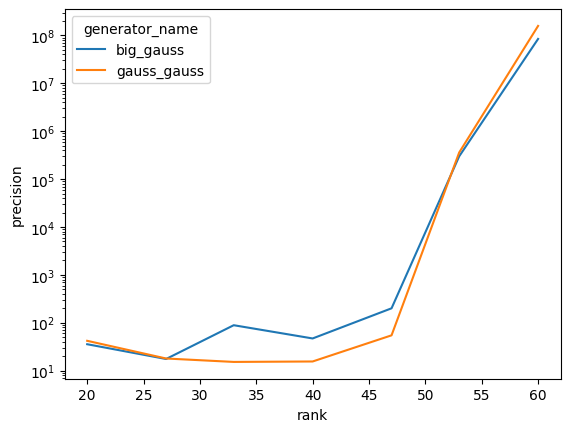

Base =  2  m =  350


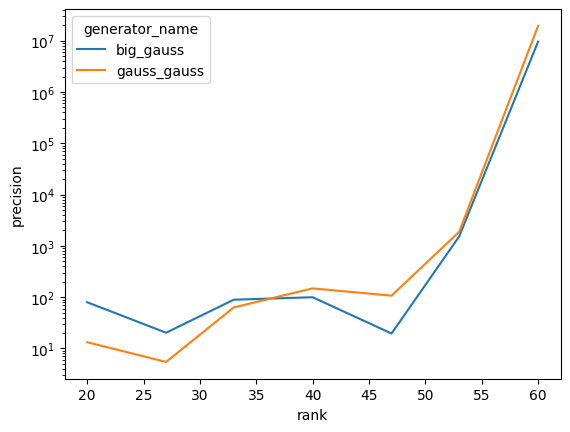

Base =  4.5  m =  70


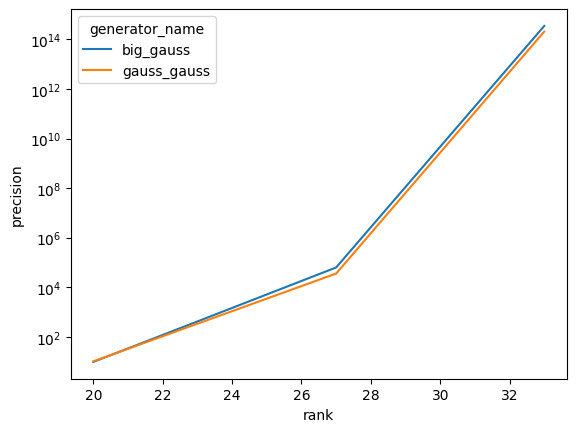

Base =  4.5  m =  140


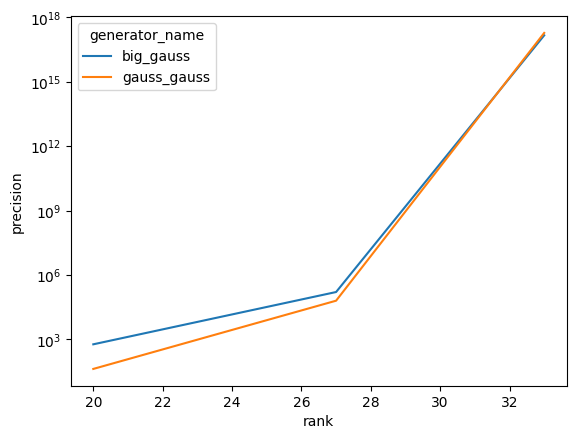

Base =  4.5  m =  210


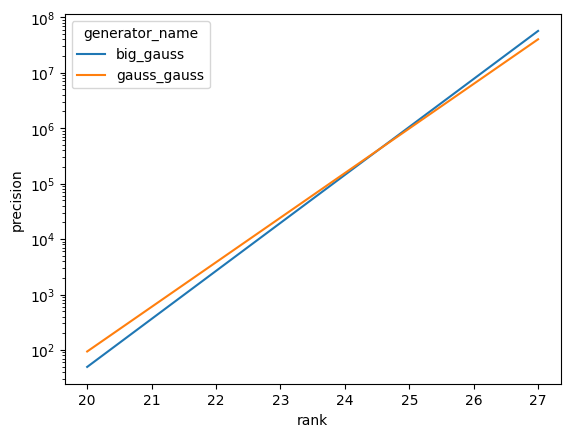

Base =  4.5  m =  280


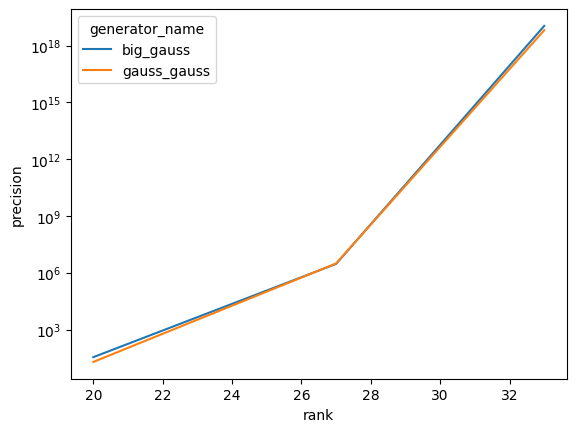

Base =  4.5  m =  350


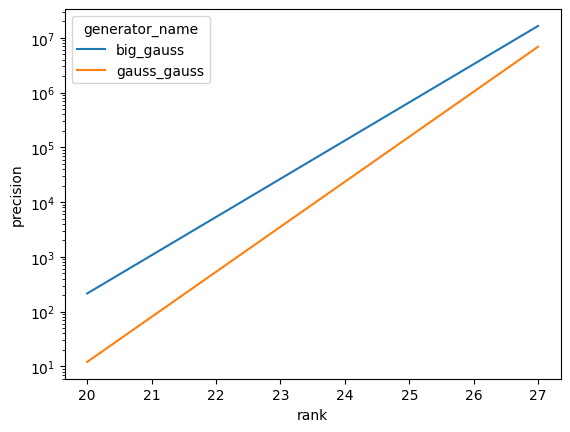

Base =  10  m =  70


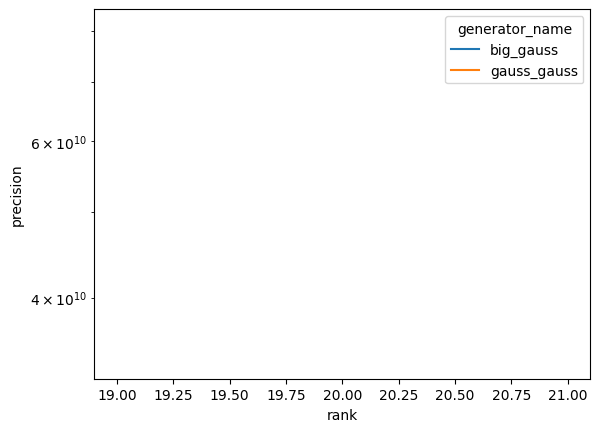

Base =  10  m =  140


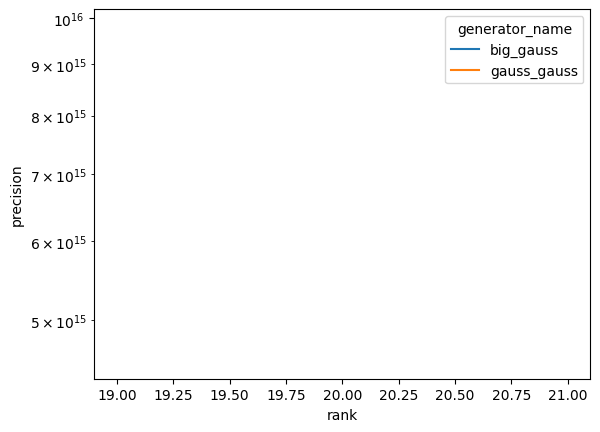

Base =  10  m =  210


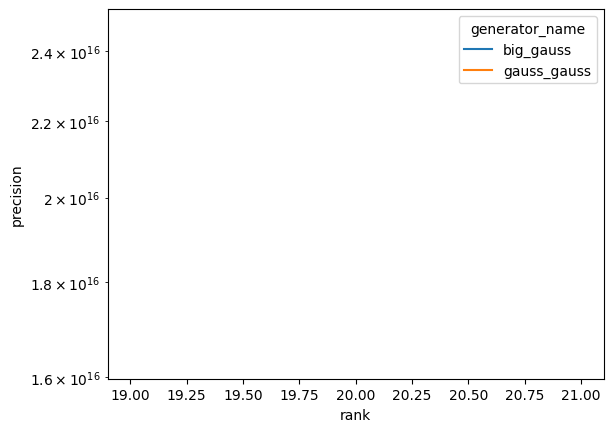

Base =  10  m =  280


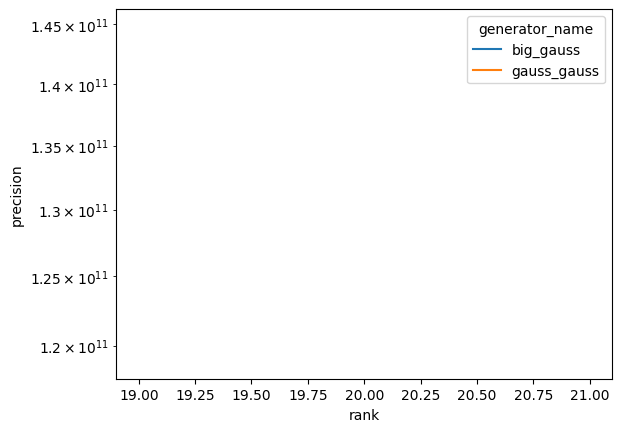

Base =  10  m =  350


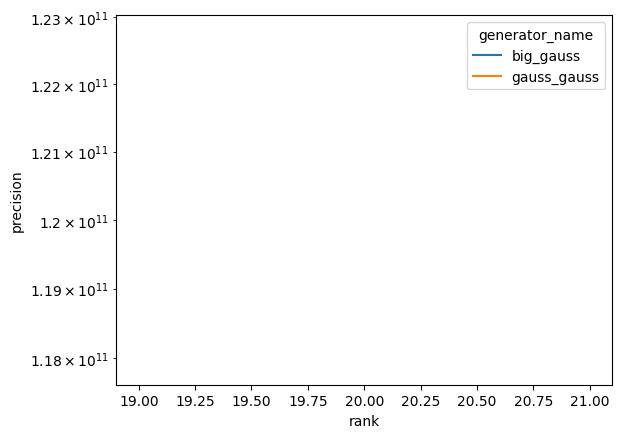

In [34]:
for base in [1.01, 1.05, 1.18, 1.5, 2, 4.5, 10]:
    for m in range (n, 5 * n + 1, n):
        print("Base = ", base, " m = ", m)
        fig, ax = plt.subplots(1, 1)
        sns.lineplot(data=df_expected[np.logical_and(df_expected["base"] == base, df_expected["row_size"] == m)], x='rank', y='precision', hue='generator_name', ax=ax)
        ax.set_yscale('log')
        plt.show()

In [ ]:
df_expected.to_csv('../experiments_results/experiment4/expected.csv')
df_variance.to_csv('../experiments_results/experiment4/variance.csv')